# <span style="color:teal"> Applied Exploratory Data Analysis, The Power of Visualization – Python, Bike-Sharing Part 1 Of 3


# <span style="color:teal"> 1. Introduction
This analysis will used a Modified Bike Sharing dataset. Unlike the original data set, this “Modified” version includes Nulls and Zeros which opened the door to perform a detail Data Exploration.

# <span style="color:teal"> 2. Feature Information

    *  dteday      : date (no time specified)
    *  season      : season (spring, summer, fall, winter)
    *  hr          : hour (0 to 23)
    *  holiday     : weather day is holiday or not
    *  weekday     : day of the week
    *  workingday  : if day is neither weekend nor holiday is 1, otherwise is 0.
    *  weathersit  : weather situation (Clear, Slightly Cloudy, Light Snow, Thunderstorm)
    *  temp        : Normalized temperature in Celsius. The values are derived via
                          (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
    *  atemp       : Normalized feeling-like temperature in Celsius. The values are derived via 
    				      (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
    *  Hum         : Normalized humidity. The values are divided to 100 (max)
    *  Windspeed   : Normalized wind speed. The values are divided to 67 (max)
    *  Cnt         : count of total rental bikes including both casual and registered



In [1]:
# Globla variable
flag_OneHotDone = False

import pandas as pd
import numpy  as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter

import category_encoders as ce 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

import calendar
from datetime import datetime

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.options.display.float_format    = '{:,.3f}'.format  
df = pd.read_csv('bikesharing_modified.csv')

ordFeatures   = ['hr']
boolFeatures  = ['holiday','workday']
contFeatures  = ['temp','atemp','hum','windspeed']
nomFeatures   = ['season','weekday','weathersit']
target        = ['cnt']

df.head()

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1/1/2011,spring,0,0,Saturday,0,Clear,0.240,0.288,0.810,0.000,16
1,1/1/2011,spring,1,0,Saturday,0,Clear,0.220,0.273,0.800,0.000,40
2,1/1/2011,spring,2,0,Saturday,0,Clear,0.220,0.273,0.800,0.000,32
3,1/1/2011,spring,3,0,Saturday,0,Clear,0.240,0.288,0.750,0.000,13
4,1/1/2011,spring,4,0,Saturday,0,Clear,0.240,0.288,0.750,0.000,1


In [2]:
df.dtypes

dteday         object
season         object
hr              int64
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

## 2.1) Feature Engineering and Encoding
The Bike Sharing data set has variety of feature types: date (dteday), ordinal (season, weekday, weathersit), ordinal (hr), boolean (holiday, workingday) continuous (temp, atemp, hum, windspeed). and counts (cnt). To facilitate data filtering, and modeling the following features and transformation are added:<br><br>

    dteday          : transformed from Object to Date-time
    year            : derived from 'dteday'
    month           : derived from 'dteday'
    month_int       : ordinal encoding of 'month';  1:Jan, 2:Feb, 3:Mar, …. 12:Dec
    season_int      : ordinal encoding of 'season'  1:spring, 2:summer, 3:fall, 4:winter
    weekday_int     : ordinal encoding of 'weekday' 0:Mond, 1:Tue, 2:Wed, 3:Thu, 4:Fri, 5:Sat, 6:Sun
    weathersit_int  : one-hot encoding of 'weathersit'
Notice that *'season'* carries ordering (i.e. Summer is followed by Fall); the encoding algorithms of SciKit-learn does not honor this ordering. The *'category_encoders'* library allows the use of dictionary-mapping to establish a custom ordering.

In [3]:
# Encoding time features
df['dteday']      = pd.to_datetime(df['dteday'])
df['year']        = df.dteday.dt.year
df['weekday']     = df.dteday.dt.strftime('%a')
df['month']       = df.dteday.dt.strftime('%b')
df['month_int']   = df.dteday.dt.month
df['weekday_int'] = df.dteday.dt.weekday

# Ordering encoding for category 'season'
df['season_int']  = df['season']
season_mapping    = [{"col":"season_int", "mapping": {'spring':1, 'summer':2, 'fall':3, 'winter':4}}]
encoder           = ce.OrdinalEncoder(cols=['season_int'],mapping = season_mapping, return_df = True, 
                            handle_unknown='return_nan', handle_missing='return_nan')  
df                = encoder.fit_transform(df)

# One-hot encoding for category 'weathersit' 
if not flag_OneHotDone:
    weathersit_dummy = pd.get_dummies(df.weathersit)
    df               = pd.concat([df, weathersit_dummy],axis=1)
    
    #   This prevent repetitive columns for One-Hot
    flag_OneHotDone = True

# <span style="color:teal"> 3) Nulls, Zeros, and Outliers
As I pointed out in the introduction, I will be using a Modified Bike Sharing data set which has nulls, zeros and outliers. This opens the door to a more detail Exploratory Data Analysis. Let’s start with Nulls, zeros, and outliers.

In [4]:
df.isna().sum()

dteday              0
season              0
hr                  0
holiday             0
weekday             0
workingday          0
weathersit          0
temp               10
atemp               0
hum                13
windspeed           0
cnt                 0
year                0
month               0
month_int           0
weekday_int         0
season_int          0
Clear               0
Light Snow          0
Slightly cloudy     0
Thunderstorm        0
dtype: int64

## 3.1) Tagging Nulls
Temperature *'temp'* and humidity *'hum'* are the only features with Null values.<br>
 To facilitate the visualization of data on graphs I created the column *'outlr_miss'* which will store the tags. Tag Values will be codified as follows: <br>

       outlr_miss    
             data  >>>  row with no Nulls or Zeros 
         temp_nan  >>>  temp column has Null values
          hum_nan  >>>  hum column has Null values
            
 After creting tags for Nulls, there should be exactly 23 rows showing either *'temp_nan'* or *'hum_nan'* tags. Observed the output of the dataframe below. 

In [5]:
# Creating columns that will Tag Nulls and Zeros. 
df['outlr_miss']='data'
df.loc[(df['outlr_miss']=='data') & df['temp'].isna(), 'outlr_miss'] = 'temp_nan' 
df.loc[(df['outlr_miss']=='data') & df['hum'].isna(), 'outlr_miss']  = 'hum_nan' 
df[df.isnull().any(axis=1)].style.highlight_null(null_color='lightgreen')

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,month_int,weekday_int,season_int,Clear,Light Snow,Slightly cloudy,Thunderstorm,outlr_miss
424,2011-01-19 00:00:00,spring,17,0,Wed,1,Clear,0.36,0.3333,nan,0.3284,197,2011,Jan,1,2,1,1,0,0,0,hum_nan
514,2011-01-23 00:00:00,spring,13,0,Sun,0,Clear,0.14,0.1061,nan,0.3881,87,2011,Jan,1,6,1,1,0,0,0,hum_nan
1251,2011-02-25 00:00:00,spring,7,0,Fri,1,Light Snow,0.34,0.3333,nan,0.1343,35,2011,Feb,2,4,1,0,1,0,0,hum_nan
1681,2011-03-15 00:00:00,spring,16,0,Tue,1,Slightly cloudy,nan,0.3939,0.46,0.3284,114,2011,Mar,3,1,1,0,0,1,0,temp_nan
3141,2011-05-15 00:00:00,summer,19,0,Sun,0,Clear,0.56,0.5303,nan,0.1045,231,2011,May,5,6,2,1,0,0,0,hum_nan
5126,2011-08-06 00:00:00,fall,12,0,Sat,0,Clear,0.8,0.7576,nan,0.2239,382,2011,Aug,8,5,3,1,0,0,0,hum_nan
6239,2011-09-22 00:00:00,fall,13,0,Thu,1,Slightly cloudy,0.66,0.6061,nan,0.194,193,2011,Sep,9,3,3,0,0,1,0,hum_nan
6953,2011-10-22 00:00:00,winter,8,0,Sat,0,Clear,nan,0.4091,0.71,0,114,2011,Oct,10,5,4,1,0,0,0,temp_nan
7566,2011-11-16 00:00:00,winter,21,0,Wed,1,Light Snow,nan,0.4394,0.88,0.2836,75,2011,Nov,11,2,4,0,1,0,0,temp_nan
7835,2011-11-28 00:00:00,winter,3,0,Mon,1,Clear,nan,0.4394,0.88,0.2239,5,2011,Nov,11,0,4,1,0,0,0,temp_nan


## 3.2) Tag Rows With Zeros
Let's check the features with Zero values. It is natural for features such as *'hr'* to shows zeros refering to hour of the day. Similar situation for boolean features such as *'holiday'* and *'workingday'*. In this dataset, zeros are suspicious in the following continuous variables: *'atemp', 'hum'*, and *'windspeed'*.

In [6]:
df.isin([0]).sum()

dteday                 0
season                 0
hr                   726
holiday            16879
weekday                0
workingday          5514
weathersit             0
temp                   0
atemp                  2
hum                   22
windspeed           2180
cnt                    0
year                   0
month                  0
month_int              0
weekday_int         2479
season_int             0
Clear               5966
Light Snow         15960
Slightly cloudy    12835
Thunderstorm       17376
outlr_miss             0
dtype: int64

Continuing with the tag encoding, the following is the tag codification for these zero-values:

     outlr_miss       
           data     >>  row with no Nulls or Zeros 
       temp_nan     >>  temp column has Null values
        hum_nan     >>  hum column has Null values
     atemp_zero     >>  atemp column has zero values
       hum_zero     >>  hum column has zero values
 windspeed_zero     >>  hum column has zero values


In [7]:
df.loc[(df['outlr_miss']=='data') & df['atemp'].isin([0]), 'outlr_miss']    = 'atemp_zero' 
df.loc[(df['outlr_miss']=='data') & df['hum'].isin([0]), 'outlr_miss']      = 'hum_zero' 
df.loc[(df['outlr_miss']=='data') & df['windspeed'].isin([0]), 'outlr_miss'] = 'windspeed_zero' 

## 3.3) Scatter Matrix Plot
Tricks I used: <br>
(1) Since plots can not handle Null values, these values are replaced with zeros at run time while feeding data to the plots. <br>
(2) To facilitate the visualization of patterns, a custom color palette is implemented

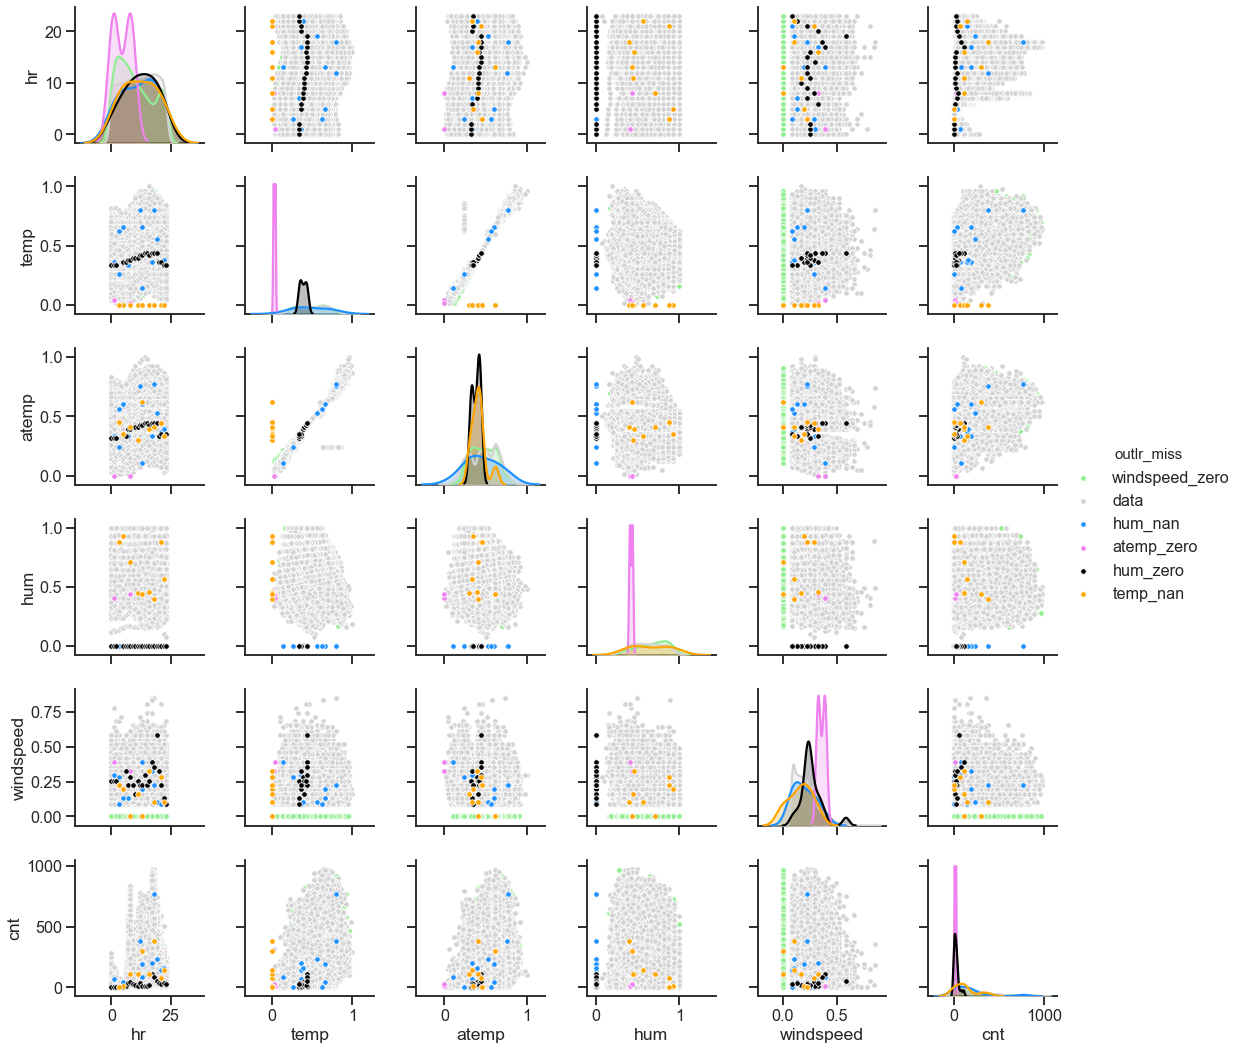

In [9]:
sns.set(context='talk', style='ticks', font_scale=0.98)
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

sns.pairplot(df[ordFeatures + contFeatures + target + ['outlr_miss']].fillna(0),
            hue="outlr_miss", palette=colorPalette, plot_kws = {'s': 30})

plt.show()
plt.close('all')

#### Tag Outliers
The scatter plot matrix releals the location of Nulls, zeros, and outliers. Especifically, plots with variabls *'temp'* and *'atemp'* show outliers, that linear strike of gray dots. The following is the code that tags these outliers. Then let's plot the scatter matrix again, this time with tags for all the suspicios point.

In [10]:
# Tagging outliers in temperature 'temp' and 'atemp'
ts = pd.to_datetime('08/17/2012')
df.loc[(df['outlr_miss']=='data') & df['dteday'].isin([ts]), 'outlr_miss'] = 'atemp_outlr' 

## 3.4) Addressing Nulls, zeros, and outliers
####  3.4.1) Addressing Nulls and Zeros in Temperature *'temp'* and *'atemp'*
Plots with Temperature *'temp'* and feeling-like temperature *'atemp'* shows these three suspicious values: Nulls, zeros, and outliers. The linear relationship between these two values becomes handy addresseing suspicious points in this case. Below the Linear Regression and its use predicting suspicious points. <br>
Observe, there are two data frames, one with the original Bike Sharing data: *'df_org'* and another with tranformed/modified data: *'atemp'*  

In [11]:
# Linear Regression to address nulls, zeros, outliers in temperature
# creating a copy of the original data set
df_cpy = df.copy(deep=True)

ftr = ['windspeed_zero', 'data', 'hum_nan','hum_zero']
# the df1 will have Nulls for variables other than 'temp' and 'atemp'
df1 = df[df_cpy.outlr_miss.isin(ftr)]

df1 = df1[['temp','atemp']].dropna()

X   = df1['temp'].values.reshape(-1,1)
y   = df1['atemp'].values.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X, y)

df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_outlr']), 'atemp'] = df_cpy['temp']*regressor.coef_[0][0] + regressor.intercept_[0] 
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_zero']), 'temp']   = df_cpy['temp']*regressor.coef_[0][0] + regressor.intercept_[0] 
df_cpy.loc[df_cpy['outlr_miss'].isin(['temp_nan']), 'temp']     = (df_cpy['atemp'] - regressor.intercept_[0])/regressor.coef_[0][0] 

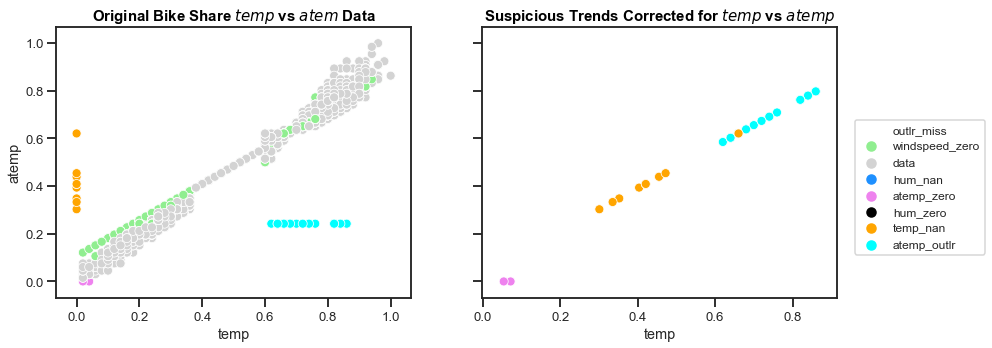

In [12]:
sns.set(context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,5)}) 

fontdictT={'fontsize': 15, 'weight' : 'bold', 'horizontalalignment': 'center'}

colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

g1 = sns.scatterplot(x='temp', y='atemp', data=df.fillna(0),
                     hue="outlr_miss", palette=colorPalette, 
                     legend='brief', ax=axes[0])

g1.set_title('Original Bike Share $temp$ vs $atem$ Data',
            fontdict=fontdictT, color="black")

colorPalette = ['violet', 'orange', 'cyan']
ftr = ['atemp_zero', 'temp_nan','atemp_outlr']
g2 = sns.scatterplot(x='temp', y='atemp', data=df_cpy[df_cpy.outlr_miss.isin(ftr)],
                     hue="outlr_miss", palette=colorPalette,
                     legend=False, ax=axes[1])

g2.set_title('Suspicious Trends Corrected for $temp$ vs $atemp$',
            fontdict=fontdictT, color="black")

g1.legend(scatterpoints=1, loc='best',
           bbox_to_anchor=(2.65, 0.7), borderaxespad=1.,
           ncol=1, fontsize=12)

plt.show()
plt.close('all')

#### Un-Tagging temperatrure values 
Temperature *'temp'* and feeling-like temperature *'atemp'* Nulls, zeros, and outliers have been corrected at this point. We dont need these tags any longer in the copy of the dataFrame: *'df_cpy'*. 

In [13]:
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_outlr']), 'outlr_miss'] = 'data'
df_cpy.loc[df_cpy['outlr_miss'].isin(['temp_nan']), 'outlr_miss']    = 'data'
df_cpy.loc[df_cpy['outlr_miss'].isin(['atemp_zero']), 'outlr_miss']  = 'data'

####  3.4.2) Addressing Nulls and Zeros in Humidity *'hum'*
Humidity is usually reported as Relative Humidity on [weather reports](http://www.fao.org/3/X0490E/x0490e07.htm). It is know tha humidity is related to temperature and dew point. As a consequence, when looking for a relationship that will help us address Nulls and zeros for humidity, the relationship should involve these variables. The Bike Sharing data set however, only give us humidity, temperature, wind speed and dates, see scatter plots below.

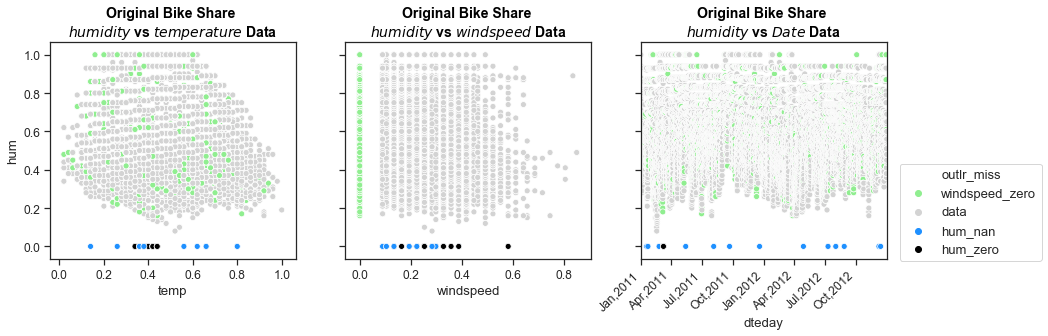

In [14]:
fontdictT    = {'fontsize': 14, 'weight' : 'bold', 'horizontalalignment': 'center'}
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

sns.set( style='ticks', font_scale=1.1, rc={'figure.figsize':(15,4)}) 

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

g = sns.scatterplot(x='temp', y='hum', data=df_cpy.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[0])
g.set_title('Original Bike Share \n$humidity$ vs $temperature$ Data',
            fontdict=fontdictT, color="black")

    
g = sns.scatterplot(x='windspeed', y='hum', data=df_cpy.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[1])
g.set_title('Original Bike Share \n$humidity$ vs $wind speed$ Data',
            fontdict=fontdictT, color="black")


g = sns.scatterplot(x='dteday', y='hum', data=df_cpy.fillna(0),
                    hue="outlr_miss", palette=colorPalette, 
                    legend = 'brief', ax=axes[2])
g.set_title('Original Bike Share \n$humidity$ vs $Date$ Data',
            fontdict=fontdictT, color="black")
g.set_xlim(xmin=df_cpy.fillna(0).dteday.min(), xmax=df_cpy.fillna(0).dteday.max())
g.xaxis.set_major_formatter(mdates.DateFormatter("%b,%Y"))
plt.setp(g.get_xticklabels(), rotation=44, ha="right")
g.legend(scatterpoints=1, loc='best', bbox_to_anchor=(1, 0.5),
         borderaxespad=1., ncol=1, fontsize=13)

plt.show()
plt.close('all')

There is not specific patterns on these plots, we need to look at more detail. We all feel it, temperatures tend to be lower during the night and early morning, then it rises during the afternoon, and lowers again at the end of the day. These behavior suggest we should look at humidity and temperature day by day. Below are plot showing humidity changes with temperature and wind speed through the day. 

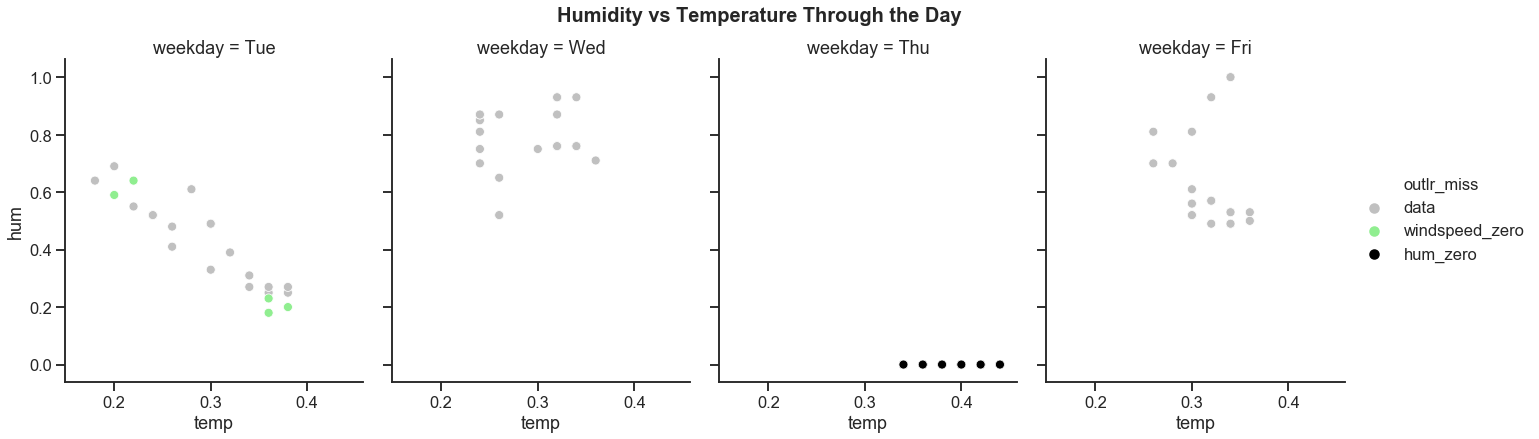

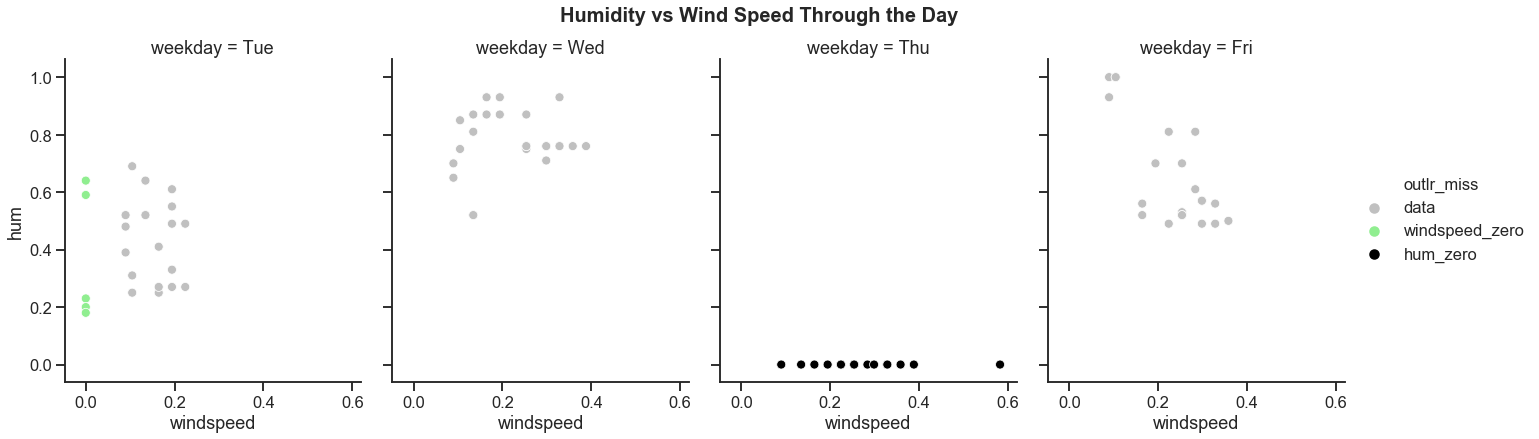

In [15]:
colorPalette = {'data':'silver', 'windspeed_zero':'lightgreen', 'hum_zero':'black', 'hum_nan':'red'}

sns.set(context='talk', style='ticks') 
g = sns.relplot(x="temp", y="hum", col="weekday", hue="outlr_miss",  
            data=df_cpy[(df_cpy.dteday>'3/07/2011') & (df_cpy.dteday<'3/12/2011')].fillna(0),
           palette=colorPalette,col_wrap=4, height=6, aspect=0.8)
g.fig.suptitle('Humidity vs Temperature Through the Day', fontsize=20, fontweight='bold', y=1.03)

g = sns.relplot(x="windspeed", y="hum", col="weekday", hue="outlr_miss", 
            data=df_cpy[(df_cpy.dteday>'3/07/2011') & (df_cpy.dteday<'3/12/2011')].fillna(0),
           palette=colorPalette, col_wrap=4, height=6, aspect=0.8)
g.fig.suptitle('Humidity vs Wind Speed Through the Day', fontsize=20, fontweight='bold', y=1.03)

plt.show()
plt.close('all')

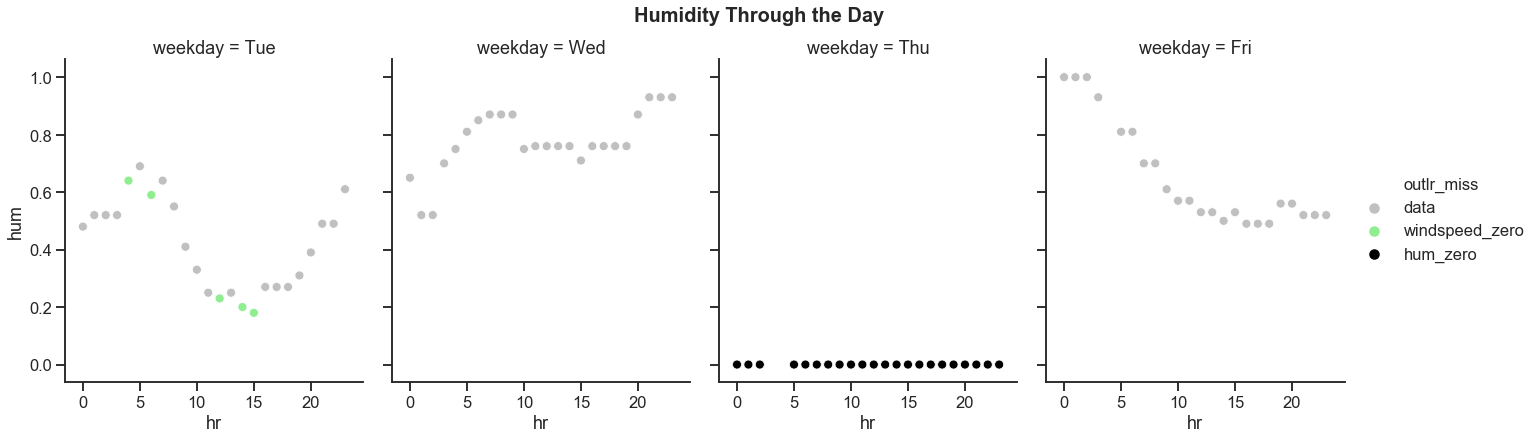

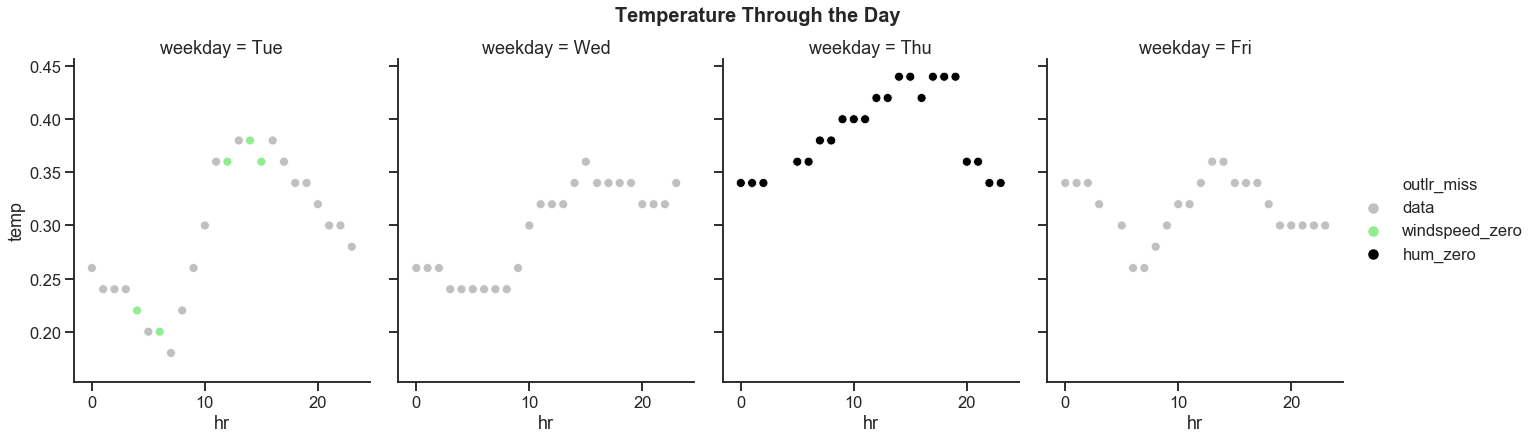

In [16]:
colorPalette = {'data':'silver', 'windspeed_zero':'lightgreen', 'hum_zero':'black', 'hum_nan':'red'}

sns.set(context='talk', style='ticks') 
g = sns.relplot(x="hr", y="hum", col="weekday", hue="outlr_miss",
            data=df_cpy[(df_cpy.dteday>'3/07/2011') & (df_cpy.dteday<'3/12/2011')].fillna(0),
           palette=colorPalette,col_wrap=4, height=6, aspect=0.8)
g.fig.suptitle('Humidity Through the Day', fontsize=20, fontweight='bold', y=1.03)

g = sns.relplot(x="hr", y="temp", col="weekday", hue="outlr_miss", 
            data=df_cpy[(df_cpy.dteday>'3/07/2011') & (df_cpy.dteday<'3/12/2011')].fillna(0),
           palette=colorPalette, col_wrap=4, height=6, aspect=0.8)
g.fig.suptitle('Temperature Through the Day', fontsize=20, fontweight='bold', y=1.03)

plt.show()
plt.close('all')

We see there is a clear relationship of temperature and humidity through the day. However, it is well know humidity is also related to dew point and that is a value abscent in the Bike Sharing data set. As a consequence, we will make use of Random Forest to address Nulls and zeros for humidity.

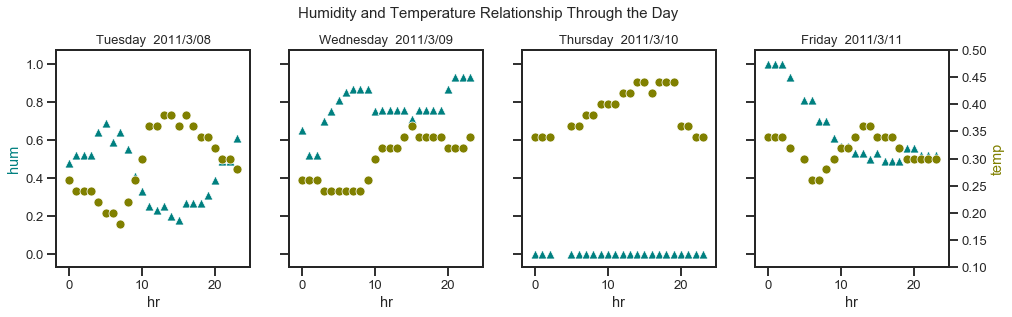

In [17]:
fontdictSubT   = {'fontsize': 13, 'horizontalalignment': 'center'}
day            = ['2011/3/08','2011/3/09','2011/3/10','2011/3/11']
sns.set(context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(16,4)}) 

n_rows, n_cols =1, 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True)
fig.suptitle('Humidity and Temperature Relationship Through the Day\n\n', fontsize=15, y=1.03)

for i, ax in enumerate(axes):
    ax1=sns.scatterplot(x="hr", y="hum", data=df_cpy[(df_cpy.dteday==day[i])].fillna(0),
                        color='teal', marker='^', ax=ax)
    ax1.yaxis.label.set_color('teal')
    week_day = calendar.day_name[datetime.strptime(day[i], '%Y/%m/%d').weekday()]
    ax1.set_title((week_day + "  " + day[i]), fontdict=fontdictSubT)

    ax2 = ax1.twinx()
    ax2 = sns.scatterplot(x="hr", y="temp", data=df_cpy[(df_cpy.dteday==day[i])].fillna(0),
                          color='olive')
    ax2.set_ylim(ymin=0.10, ymax=.5)
    ax2.yaxis.label.set_color('olive')
    if i != (n_cols-1): ax2.get_yaxis().set_visible(False) 

plt.show()
plt.close('all')

##### * Random Forest to Address Nulls and Zeros in *'humidity'*
The relationship between *'humidity, tenperature,'* and *'dew point'* is not linear; theresfore, a Random Forest Regressor is a great starting point to address Nulls and zeros for *'humidity'*. In order to do so, we need to perform a) create training data set with *'humidity'* values other than zero and Null, b) train and predict Nulls and zeros with Random Forest.

> a) Creating Training Data Set for Random Forest with 'humidity' values other than zero and Null

In [18]:
df_Train = df_cpy.copy(deep=True)
df_Test  = df_cpy.copy(deep=True)

options  = [np.nan, 0]
df_Train = df_Train.loc[df_Train.hum.isin(options)==False]
df_Test  = df_Test.loc[df_Test['hum'].isin(options)]
df_Test.drop(columns = ['hum'], inplace=True)

> b) train and predict Nulls and zeros with Random Forest.

In [19]:
predictors = ['month_int','weekday_int','hr','Clear','Light Snow','Slightly cloudy','Thunderstorm','temp']
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(df_Train[predictors], df_Train['hum'])
df_Test['hum'] = rfr.predict(X = df_Test[predictors])
df_cpy2 = pd.concat([df_Train,df_Test],axis='rows', sort=False)
df_cpy2.sort_index(inplace=True)

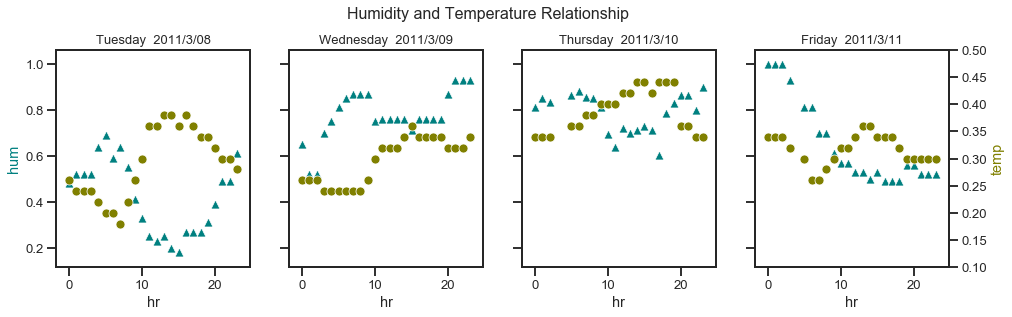

In [20]:
fontdictSubT   = {'fontsize': 13, 'horizontalalignment': 'center'}
day            = ['2011/3/08','2011/3/09','2011/3/10','2011/3/11']
sns.set(context='talk', style='ticks', font_scale=0.8) 


n_rows, n_cols =1, 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True)
fig.suptitle('Humidity and Temperature Relationship\n\n', fontsize=16, y=1.03)

for i, ax in enumerate(axes):
    ax1=sns.scatterplot(x="hr", y="hum", data=df_cpy2[(df_cpy.dteday==day[i])].fillna(0),
                        color='teal', marker='^', ax=ax)
    ax1.yaxis.label.set_color('teal')
    week_day = calendar.day_name[datetime.strptime(day[i], '%Y/%m/%d').weekday()]
    ax1.set_title((week_day + "  " + day[i]), fontdict=fontdictSubT)

    ax2 = ax1.twinx()
    ax2 = sns.scatterplot(x="hr", y="temp", data=df_cpy2[(df_cpy.dteday==day[i])].fillna(0),
                          color='olive')
    ax2.set_ylim(ymin=0.10, ymax=.5)
    ax2.yaxis.label.set_color('olive')
    if i != (n_cols-1): ax2.get_yaxis().set_visible(False) 

plt.show()
plt.close('all')

####  3.4.3) Addressing Zeros in *'windspeed'*
We use Random Forest to address zeros in wind speed as well. a) create training data set with *'windspeed'* values other than zero, b) train and predict zeros with Random Forest.

In [21]:
df_Train = df_cpy2.copy(deep=True)
df_Test  = df_cpy2.copy(deep=True)

options  = [np.nan, 0]
df_Train = df_Train.loc[df_Train.windspeed.isin(options)==False]
df_Test  = df_Test.loc[df_Test['windspeed'].isin(options)]
df_Test.drop(columns = ['windspeed'], inplace=True)


# Training the regressor
predictors = ['season_int','hr','weekday_int','Clear','Light Snow','Slightly cloudy','Thunderstorm','temp','hum']
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(df_Train[predictors], df_Train['windspeed'])

df_Test['windspeed'] = rfr.predict(X = df_Test[predictors])

df_cpy3 = pd.concat([df_Train,df_Test],axis='rows', sort=False)
df_cpy3.sort_values(by='dteday')

,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,year,month,month_int,weekday_int,season_int,Clear,Light Snow,Slightly cloudy,Thunderstorm,outlr_miss
5,2011-01-01,spring,5,0,Sat,0,Slightly cloudy,0.240,0.258,0.750,...,2011,Jan,1,5,1.000,0,0,1,0,data
2,2011-01-01,spring,2,0,Sat,0,Clear,0.220,0.273,0.800,...,2011,Jan,1,5,1.000,1,0,0,0,windspeed_zero
3,2011-01-01,spring,3,0,Sat,0,Clear,0.240,0.288,0.750,...,2011,Jan,1,5,1.000,1,0,0,0,windspeed_zero
4,2011-01-01,spring,4,0,Sat,0,Clear,0.240,0.288,0.750,...,2011,Jan,1,5,1.000,1,0,0,0,windspeed_zero
6,2011-01-01,spring,6,0,Sat,0,Clear,0.220,0.273,0.800,...,2011,Jan,1,5,1.000,1,0,0,0,windspeed_zero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17357,2012-12-31,spring,2,0,Mon,1,Clear,0.160,0.167,0.590,...,2012,Dec,12,0,1.000,1,0,0,0,data
17356,2012-12-31,spring,1,0,Mon,1,Clear,0.180,0.182,0.550,...,2012,Dec,12,0,1.000,1,0,0,0,data
17378,2012-12-31,spring,23,0,Mon,1,Clear,0.260,0.273,0.650,...,2012,Dec,12,0,1.000,1,0,0,0,data
17365,2012-12-31,spring,10,0,Mon,1,Slightly cloudy,0.200,0.212,0.690,...,2012,Dec,12,0,1.000,0,0,1,0,data


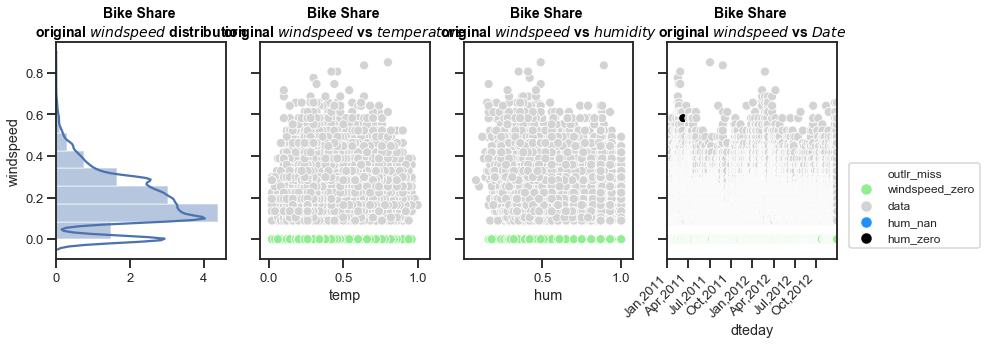

In [22]:
fontdictT    = {'fontsize': 14, 'weight' : 'bold', 'horizontalalignment': 'center', 'color':"black"}
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

sns.set( context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,4)}) 
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True)

g = sns.distplot(df_cpy2.windspeed.fillna(0), bins=10, vertical=True, ax=axes[0])
g.set_title('Bike Share \noriginal $wind speed$ distribution', fontdict=fontdictT)


g = sns.scatterplot(x='temp', y='windspeed', data=df_cpy2.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[1])
g.set_title('Bike Share \noriginal $wind speed$ vs $temperature$', fontdict=fontdictT)

    
g = sns.scatterplot(x='hum', y='windspeed', data=df_cpy2.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[2])
g.set_title('Bike Share \noriginal $wind speed$ vs $humidity$', fontdict=fontdictT) 


g = sns.scatterplot(x='dteday', y='windspeed', data=df_cpy2.fillna(0),
                    hue="outlr_miss", palette=colorPalette, 
                    legend = 'brief', ax=axes[3])
g.set_title('Bike Share \noriginal $wind speed$ vs $Date$', fontdict=fontdictT)
g.set_xlim(xmin=df_cpy2.fillna(0).dteday.min(), xmax=df_cpy2.fillna(0).dteday.max())
g.xaxis.set_major_formatter(mdates.DateFormatter("%b,%Y"))
plt.setp(g.get_xticklabels(), rotation=45, ha="right")
g.legend(scatterpoints=1, loc='best', bbox_to_anchor=(1, 0.5),
         borderaxespad=1., ncol=1, fontsize=12)

plt.show()
plt.close('all')

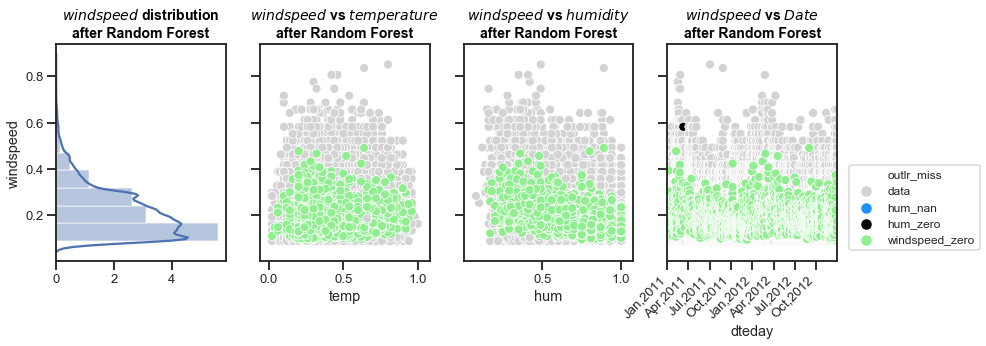

In [23]:
fontdictT    = {'fontsize': 14, 'weight' : 'bold', 'horizontalalignment': 'center', 'color':"black"}
colorPalette = {'data':'lightgray', 'windspeed_zero':'lightgreen', 
                'hum_zero':'black', 'hum_nan':'dodgerblue',
               'temp_nan':'orange', 'atemp_zero':'violet', 'atemp_outlr':'cyan'}

sns.set( context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,4)}) 
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True)

g = sns.distplot(df_cpy3.windspeed.fillna(0), bins=10, vertical=True, ax=axes[0])
g.set_title('$wind speed$ distribution \nafter Random Forest', fontdict=fontdictT)


g = sns.scatterplot(x='temp', y='windspeed', data=df_cpy3.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[1])
g.set_title('$wind speed$ vs $temperature$ \nafter Random Forest', fontdict=fontdictT)

    
g = sns.scatterplot(x='hum', y='windspeed', data=df_cpy3.fillna(0),
                    hue="outlr_miss", palette=colorPalette,
                    legend = False, ax=axes[2])
g.set_title('$wind speed$ vs $humidity$ \nafter Random Forest', fontdict=fontdictT) 


g = sns.scatterplot(x='dteday', y='windspeed', data=df_cpy3.fillna(0),
                    hue="outlr_miss", palette=colorPalette, 
                    legend = 'brief', ax=axes[3])
g.set_title('$wind speed$ vs $Date$ \nafter Random Forest', fontdict=fontdictT)
g.set_xlim(xmin=df_cpy2.fillna(0).dteday.min(), xmax=df_cpy3.fillna(0).dteday.max())
g.xaxis.set_major_formatter(mdates.DateFormatter("%b,%Y"))
plt.setp(g.get_xticklabels(), rotation=45, ha="right")
g.legend(scatterpoints=1, loc='best', bbox_to_anchor=(1, 0.5),
         borderaxespad=1., ncol=1, fontsize=12)

plt.show()
plt.close('all')

# <span style="color:teal"> 4) Correlation Matrix - Collinearity Assessemnt
* Temperature *'temp'* and feeling-like temperature *'atemp'* are highly correlated, one variable can tell us about the other. Feeling-like temperature will be dropped off from the analysis as it is referenced to *'temp'*.
* Bicycle counts show a positive correlation with temperature and a negative correlation with humidity. This can be confirmed with the bottom row of the scatter plot matrix shown in previous sections. However, these trends should be analyzed simultaneously with the time dimension. We will elaborate on this in the next sections.

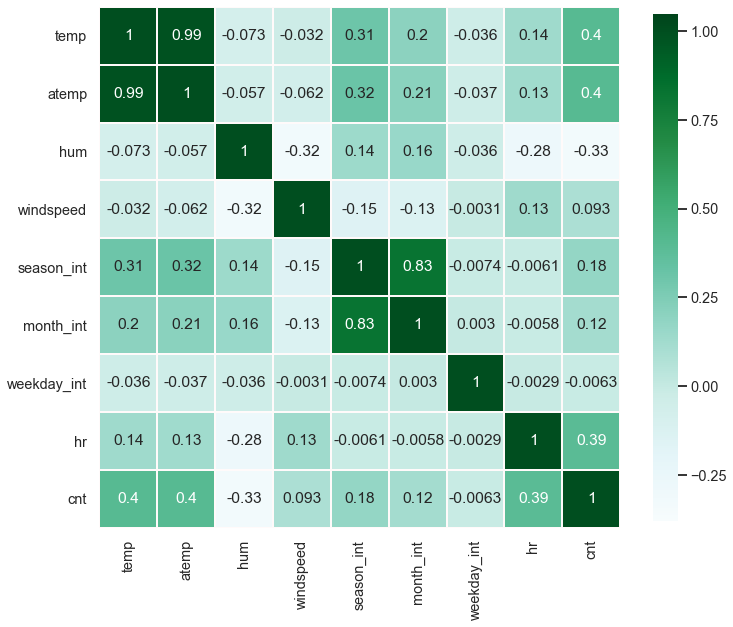

In [24]:
corr_mtx = df_cpy3[["temp","atemp","hum","windspeed","season_int","month_int","weekday_int","hr","cnt"]].corr()

w = 12
h = 12
d = 70
sns.set( context='talk', style='whitegrid', font_scale=0.9) 
plt.figure(figsize=(w, h), dpi=d)
ax = sns.heatmap(data=corr_mtx, annot=True, square=True, linewidths=1, linecolor='snow', 
                 vmin=np.nanmin(corr_mtx)-0.05, vmax=np.nanmax(corr_mtx)+0.05,
                 cbar_kws={"shrink": .8}, cmap='BuGn')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
plt.close('all')

# <span style="color:teal"> 5) Univariate Behavior - Response Variable
The dictribution of bicycle counts is right skewed, a logarithmic transformation brings the distribution close to normality. This is a needed transformtion that will have a positive impact in any modeling.

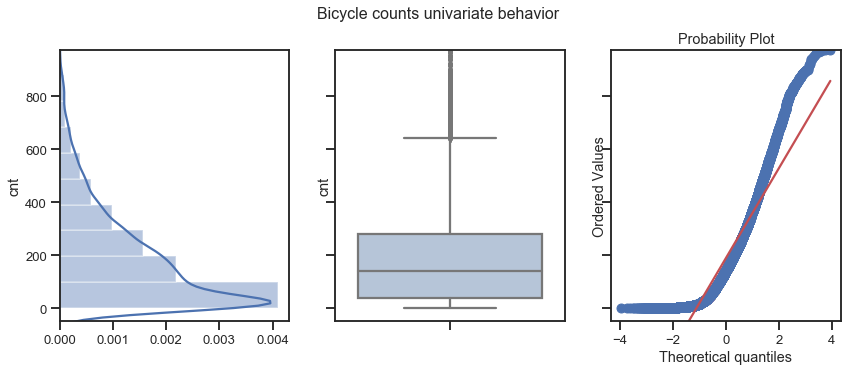

In [25]:
sns.set( context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,5)}) 
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
fig.suptitle('Bicycle counts univariate behavior', fontsize=16, y=1)

g = sns.distplot(df_cpy3.cnt, bins=10, vertical=True, ax=axes[0])
g.set_ylim(ymin=df_cpy3.cnt.min()-50, ymax=df_cpy3.cnt.max())
g = sns.boxplot(y='cnt', data=df_cpy3, color='lightsteelblue', ax=axes[1])
g = stats.probplot(df_cpy3.cnt, dist='norm', fit=True, plot=axes[2])
plt.show()
plt.close('all')

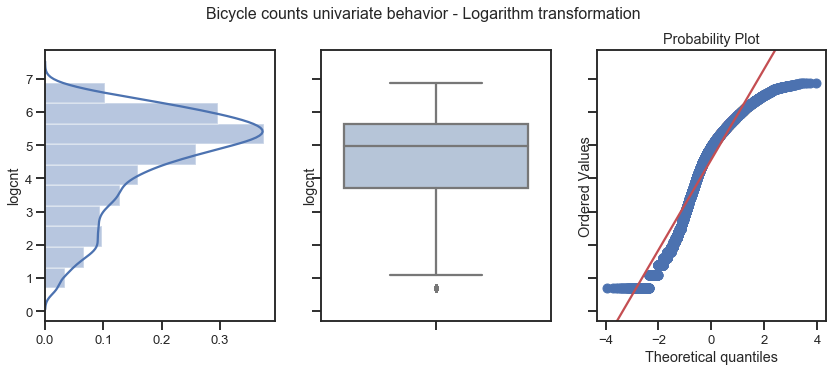

In [26]:
sns.set( context='talk', style='ticks', font_scale=0.8, rc={'figure.figsize':(14,5)}) 
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
fig.suptitle('Bicycle counts univariate behavior - Logarithm transformation', fontsize=16, y=1)

df_cpy3['logcnt'] = np.log(df_cpy3['cnt']+1)
g = sns.distplot(df_cpy3.logcnt, bins=10, vertical=True, ax=axes[0])
g.set_ylim(ymin=df_cpy3.logcnt.min()-1, ymax=df_cpy3.logcnt.max()+1)
g = sns.boxplot(y='logcnt', data=df_cpy3, color='lightsteelblue', ax=axes[1])
g = stats.probplot(df_cpy3.logcnt, dist='norm', fit=True, plot=axes[2])
plt.show()
plt.close('all')

# <span style="color:teal"> 6) Behavior of Response Variable With Time Variables

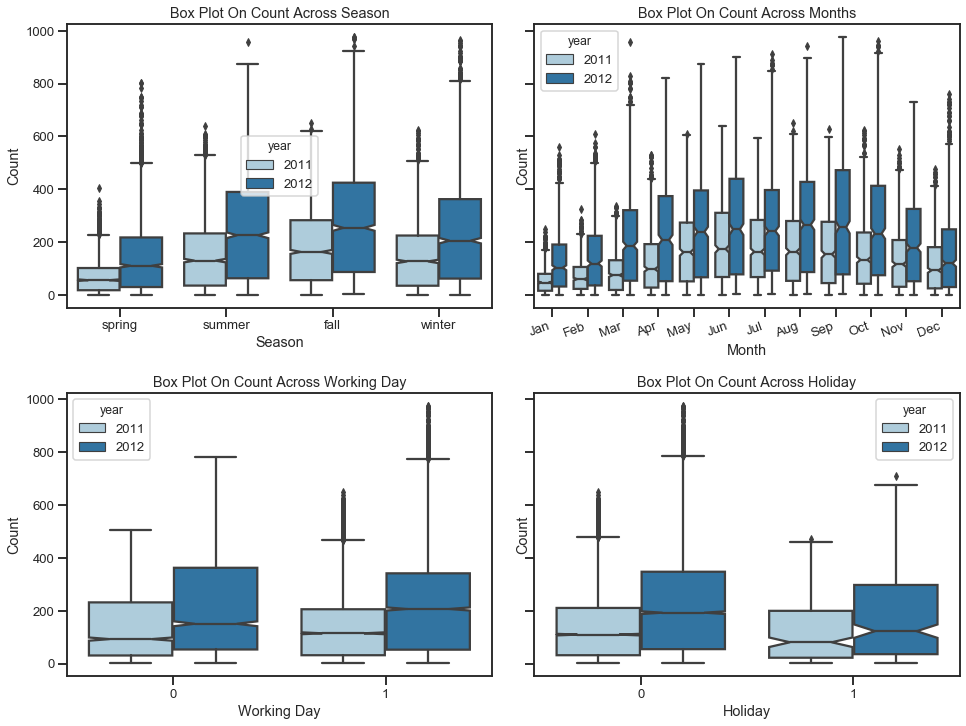

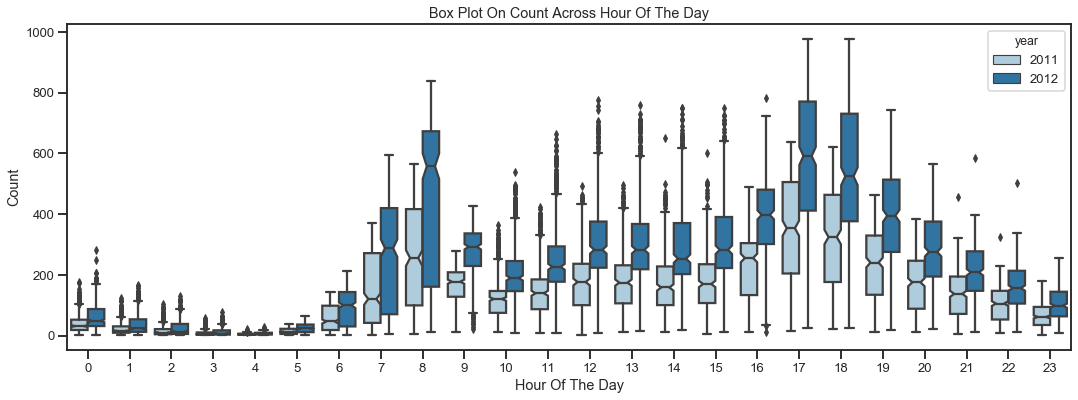

In [27]:
sns.set(context='talk', style='ticks', font_scale=0.8, palette="Paired")
fig, axes = plt.subplots(nrows=2,ncols=2, sharey=True, figsize=(16,12))
fig.subplots_adjust(hspace=0.3, wspace=0.10)


sns.boxplot(y="cnt",x="season", data=df_cpy3, orient="v", hue='year', notch=True, ax=axes[0][0])
g = sns.boxplot(y="cnt",x="month", data=df_cpy3, orient="v", hue='year', notch=True, ax=axes[0][1])
plt.setp(g.get_xticklabels(), rotation=20, ha="right")
sns.boxplot(y="cnt",x="workingday", data=df_cpy3, orient="v", hue='year', notch=True, ax=axes[1][0])
sns.boxplot(y="cnt",x="holiday", data=df_cpy3, orient="v", hue='year', notch=True, ax=axes[1][1])


axes[0][0].set(xlabel='Season', ylabel='Count', title="Box Plot On Count Across Season")
axes[0][1].set(xlabel='Month', ylabel='Count', title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][1].set(xlabel='Holiday', ylabel='Count', title="Box Plot On Count Across Holiday")


sns.set(context='talk', style='ticks', font_scale=0.8,palette="Paired")
fig, axes = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(18,6))
sns.boxplot(y="cnt",x="hr", data=df_cpy3, orient="v", hue='year', notch=True, ax=axes)
axes.set(xlabel='Hour Of The Day', ylabel='Count', title="Box Plot On Count Across Hour Of The Day")
plt.show()
plt.close('all')

<Figure size 1008x360 with 0 Axes>

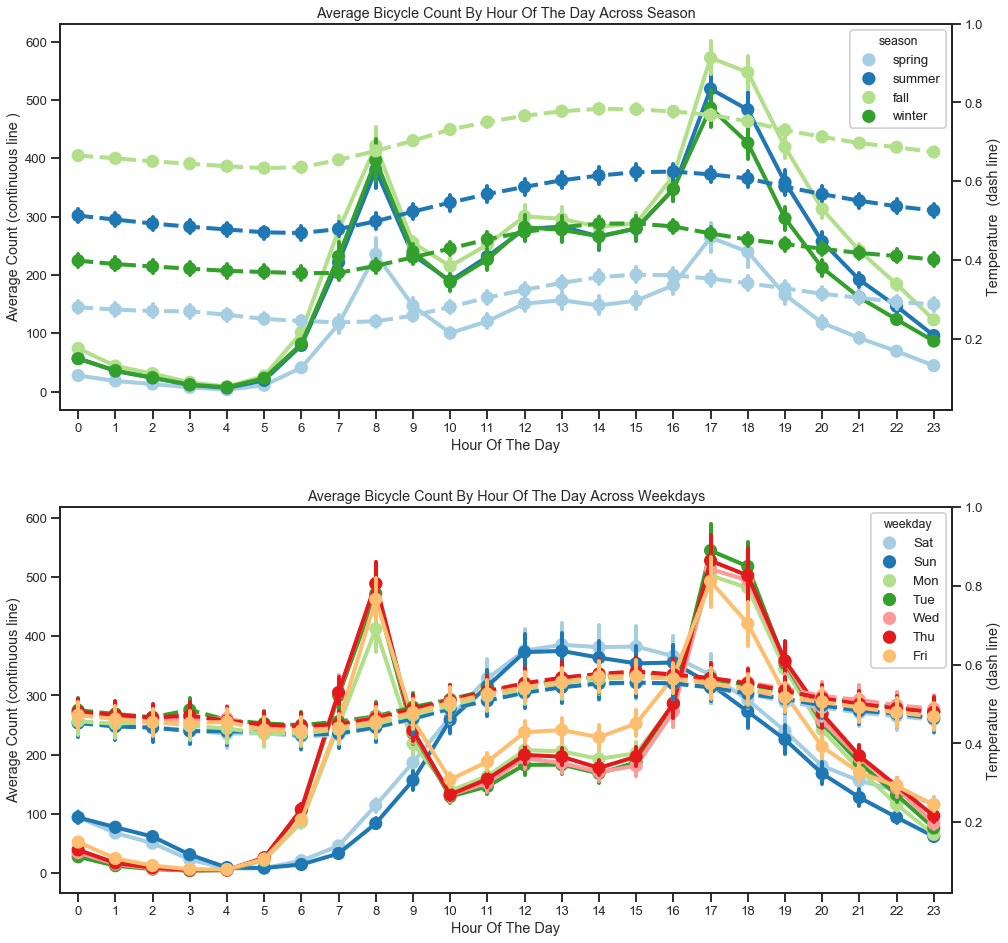

In [28]:
fig = plt.figure()
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(16,16))
fig.subplots_adjust(hspace=0.25, wspace=0.12)

seasonOrder  = ['spring','summer','fall','winter']
WeekdayOrder = ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri']


ax1 = sns.pointplot(x="hr", y="cnt",hue="season",  hue_order=seasonOrder, data=df_cpy3, 
                    palette='Paired', ax=axes[0])
ax1.set(xlabel='Hour Of The Day', ylabel='Average Count (continuous line )', 
        title ="Average Bicycle Count By Hour Of The Day Across Season", label='big')

ax1a = ax1.twinx()
ax1a = sns.pointplot(x="hr", y="temp", hue="season", hue_order=seasonOrder, data=df_cpy3, 
                     palette='Paired', linestyles=["--","--","--","--"])
ax1a.set(ylabel='Temperature  (dash line)', label='big', ylim=(df_cpy3.temp.min(),df_cpy3.temp.max())) 




ax2 = sns.pointplot(x="hr", y="cnt", hue="weekday", hue_order=WeekdayOrder, data=df_cpy3,
                    palette='Paired',ax=axes[1])
ax2.set(xlabel='Hour Of The Day', ylabel='Average Count (continuous line)',
        title="Average Bicycle Count By Hour Of The Day Across Weekdays",label='big')
        
ax2a = ax2.twinx()
ax2a = sns.pointplot(x="hr", y="temp", hue="weekday", hue_order=WeekdayOrder, data=df_cpy3,
                     palette='Paired', linestyles=["--","--","--","--","--","--","--"])
ax2a.set(ylabel='Temperature  (dash line)', label='big', ylim=(df_cpy3.temp.min(),df_cpy3.temp.max()))


plt.show()
plt.close('all')

### Write the latest dataframe 'cured' for nulls, zeros, and outliers

In [29]:
df_cpy3.to_csv('bikeSharing_modified_cured.csv')